# Model Comparison Notebook

This notebook provides tools for comparing performance across different trained models:
- test set accuracy evaluation
- confusion matrix analysis
- per-class and group accuracy
- dropout vs. overfitting plots
- efficiency vs. accuracy tradeoffs


In [1]:
# Standard library
import sys
import os
import numpy as np

# Project root and paths
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from utils.paths import MODELS_DIR, DATA_DIR, ARCHITECTURES_DIR

# Data and evaluation utilities
from utils.data_utils import evaluate_all_models_on_test

# Visualization tools
from utils.visualization import (
    build_comparison_table, plot_model_comparison,
    plot_val_vs_test_acc, plot_dropout_vs_overfit,
    plot_efficiency, plot_group_accuracy,
    interactive_model_comparison
)


## Model Performance Summary

This section summarizes all trained models with key metrics:
- Best validation accuracy and training accuracy
- Overfitting gap and stability
- Average epoch time and optimizer used


,Model,Type,Architecture,Optimizer,Dropout,LR,Epoch (best),Train Acc,Val Acc,Val Loss,Overfit Gap,Avg Epoch Time (s),Converged by Epoch,Stability (val acc)
0,cnn_bn_32_64_128_fc512_256_aug_sched,CNN,"conv: 3, fc: 2",Adam,"[0.5, 0.3]",0.000500,71,0.823600,0.807300,0.586600,0.016300,27.680000,21,0.002099
1,cnn_bn_32_64_128_fc_512_256_aug,CNN,"conv: 3, fc: 2",Adam,"[0.5, 0.3]",0.000500,83,0.816700,0.796900,0.612700,0.019800,34.250000,18,0.003274
2,cnn_bn_32_64_128_256_fc512_256_aug_sched_SGD,CNN,"conv: 4, fc: 2",SGD,"[0.5, 0.3]",0.010000,13,0.998300,0.770500,1.083100,0.227800,16.630000,3,0.001013
3,cnn_mixup_cutout_SGD,CNN,"conv: 4, fc: 2",SGD,"[0.5, 0.3]",0.010000,55,0.436200,0.770400,1.077900,-0.334200,28.320000,20,0.002521
4,cnn_advanced,CNN,"conv: 3, fc: 2",Adam,"[0.5, 0.3]",0.000500,12,0.835000,0.744300,0.804000,0.090700,24.030000,5,0.003845
5,cnn_64_128_256_fc_512,CNN,"conv: 3, fc: 1",Adam,[0.4],0.000500,16,0.978700,0.744200,1.445000,0.234500,24.460000,3,0.002395
6,cnn_bn_32_64_128_fc_512_256,CNN,"conv: 3, fc: 2",Adam,"[0.5, 0.3]",0.000500,11,0.932100,0.725400,1.003600,0.206700,25.990000,2,0.006529
7,cnn_test,CNN,"conv: 2, fc: 2",Adam,"[0.3, 0.3]",0.001000,12,0.847100,0.722200,0.881400,0.124900,24.420000,3,0.003878
8,cnn_bn_32_64_128_fc_512_256_gs,CNN,"conv: 3, fc: 2",Adam,"[0.5, 0.3]",0.000500,11,0.913300,0.697900,1.056400,0.215400,26.400000,2,0.006637
9,fc_1024_512_256,FC,fc: 3,SGD,"[0.3, 0.3, 0.3]",0.010000,28,0.703400,0.578700,1.268500,0.124700,23.610000,6,0.006051


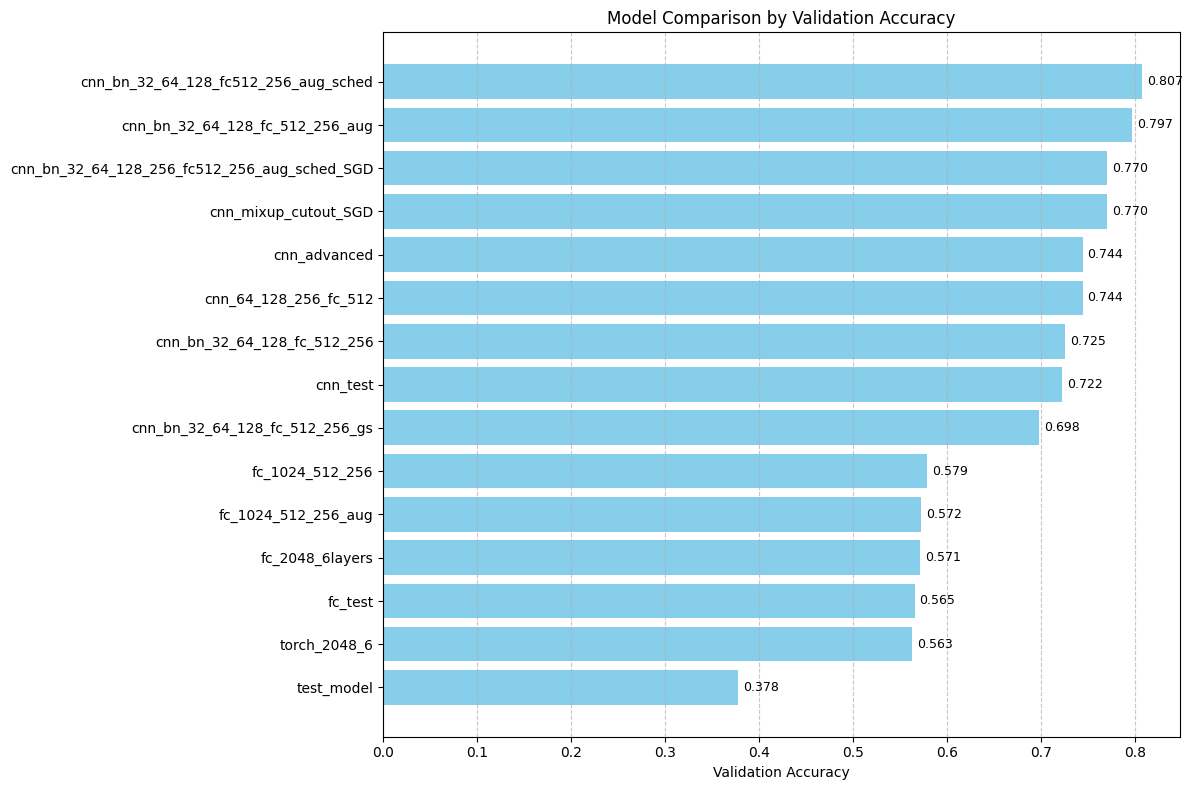

✅ Best model: cnn_bn_32_64_128_fc512_256_aug_sched with 0.8073 val accuracy


In [2]:
df_models = build_comparison_table(models_dir=MODELS_DIR).sort_values(by="Val Acc", ascending=False)
styled_df_models = df_models.style.bar(subset=["Val Acc", "Train Acc", "Overfit Gap", "Stability (val acc)"], color='lightblue')
display(styled_df_models)

plot_model_comparison(df_models)

best_model = df_models.loc[df_models["Val Acc"].idxmax()]
print(f"✅ Best model: {best_model['Model']} with {best_model['Val Acc']:.4f} val accuracy")

#### Evaluate Models on Test Set

In this section, each trained model is evaluated on the test dataset.

- ✅ If cached results exist (`force=False`), they are loaded to save time.
- 🔁 If needed, set `force=True` to re-run the evaluation and overwrite cached results.
- 💾 Test predictions are saved to JSON files (`save_predictions=True`) to allow for later analysis and visualization.

In [3]:
# Evaluate all models on the test set and update main table
print("\n📊 Evaluating all models on the test set...\n")
test_results, class_names = evaluate_all_models_on_test(models_dir=MODELS_DIR, force=False, save_predictions=True)

for model_name, metrics in test_results.items():
    if model_name in df_models["Model"].values:
        df_models.loc[df_models["Model"] == model_name, "Test Acc"] = round(metrics["accuracy"], 4)
        df_models.loc[df_models["Model"] == model_name, "Test Loss"] = round(metrics["loss"], 4)

print(f"\n✅ Updated test accuracy and loss for {len(test_results)} models.")


📊 Evaluating all models on the test set...

------------------------------------------------------------
Evaluating cnn_64_128_256_fc_512...
------------------------------------------------------------
✅ Test results already exist for cnn_64_128_256_fc_512.. loading from c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\models\cnn_64_128_256_fc_512\cnn_64_128_256_fc_512_test.json
------------------------------------------------------------
Evaluating cnn_advanced...
------------------------------------------------------------
✅ Test results already exist for cnn_advanced.. loading from c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\models\cnn_advanced\cnn_advanced_test.json
------------------------------------------------------------
Evaluating cnn_bn_32_64_128_256_fc512_256_aug_sched_SGD...
------------------------------------------------------------
✅ Test results already exist for cnn_bn_32_64_128_256_fc512_256_aug_sched_SGD.. loadin

,Model,Type,Architecture,Optimizer,Dropout,LR,Epoch (best),Train Acc,Val Acc,Test Acc,Val Loss,Test Loss,Overfit Gap,Avg Epoch Time (s),Converged by Epoch,Stability (val acc)
0,cnn_bn_32_64_128_fc512_256_aug_sched,CNN,"conv: 3, fc: 2",Adam,"[0.5, 0.3]",0.000500,71,0.823600,0.807300,0.844700,0.586600,0.452000,0.016300,27.680000,21,0.002099
3,cnn_mixup_cutout_SGD,CNN,"conv: 4, fc: 2",SGD,"[0.5, 0.3]",0.010000,55,0.436200,0.770400,0.835700,1.077900,0.914700,-0.334200,28.320000,20,0.002521
1,cnn_bn_32_64_128_fc_512_256_aug,CNN,"conv: 3, fc: 2",Adam,"[0.5, 0.3]",0.000500,83,0.816700,0.796900,0.830900,0.612700,0.490000,0.019800,34.250000,18,0.003274
2,cnn_bn_32_64_128_256_fc512_256_aug_sched_SGD,CNN,"conv: 4, fc: 2",SGD,"[0.5, 0.3]",0.010000,13,0.998300,0.770500,0.758400,1.083100,1.103500,0.227800,16.630000,3,0.001013
5,cnn_64_128_256_fc_512,CNN,"conv: 3, fc: 1",Adam,[0.4],0.000500,16,0.978700,0.744200,0.733400,1.445000,0.786600,0.234500,24.460000,3,0.002395
4,cnn_advanced,CNN,"conv: 3, fc: 2",Adam,"[0.5, 0.3]",0.000500,12,0.835000,0.744300,0.723000,0.804000,0.806100,0.090700,24.030000,5,0.003845
7,cnn_test,CNN,"conv: 2, fc: 2",Adam,"[0.3, 0.3]",0.001000,12,0.847100,0.722200,0.711200,0.881400,0.849300,0.124900,24.420000,3,0.003878
6,cnn_bn_32_64_128_fc_512_256,CNN,"conv: 3, fc: 2",Adam,"[0.5, 0.3]",0.000500,11,0.932100,0.725400,0.693600,1.003600,0.874500,0.206700,25.990000,2,0.006529
8,cnn_bn_32_64_128_fc_512_256_gs,CNN,"conv: 3, fc: 2",Adam,"[0.5, 0.3]",0.000500,11,0.913300,0.697900,0.690000,1.056400,0.911000,0.215400,26.400000,2,0.006637
11,fc_2048_6layers,FC,fc: 6,Adam,"[0.3, 0.3, 0.3, 0.3, 0.3, 0.3]",0.001000,30,0.768200,0.571100,0.570400,1.412500,1.287500,0.197100,17.280000,7,0.003072


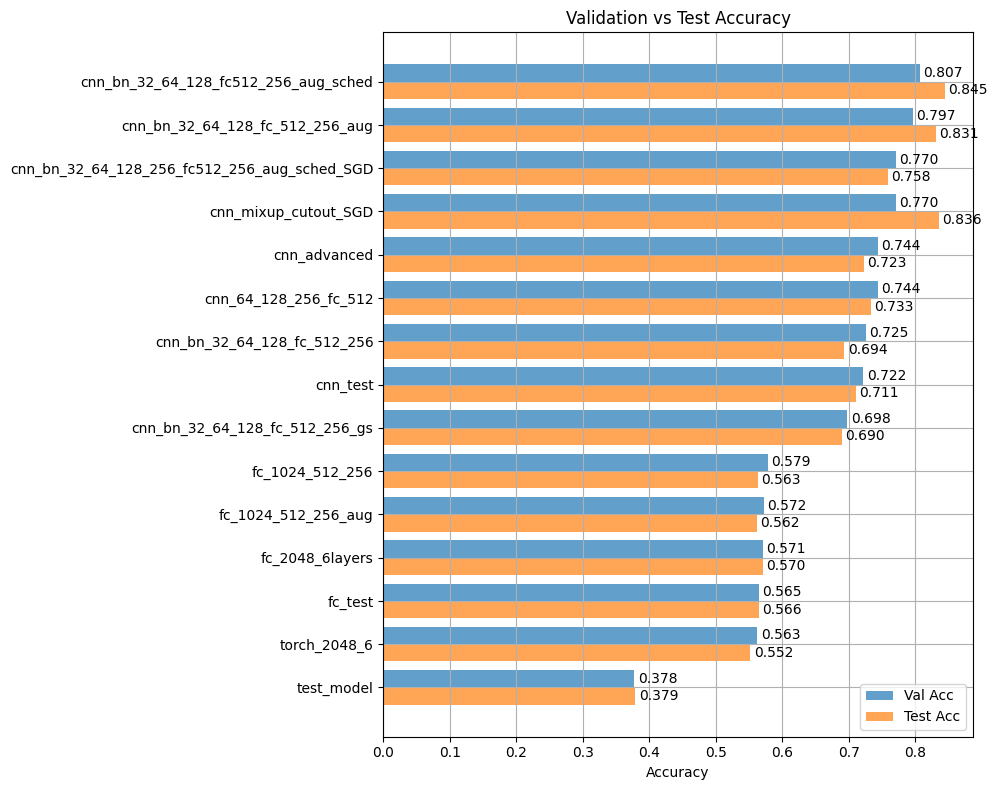

In [4]:
columns_order = [
    "Model", "Type", "Architecture", "Optimizer", "Dropout", "LR",
    "Epoch (best)", "Train Acc", "Val Acc", "Test Acc",
    "Val Loss", "Test Loss", "Overfit Gap",
    "Avg Epoch Time (s)", "Converged by Epoch", "Stability (val acc)"
]
df_models = df_models[columns_order]
styled_df_models = df_models.sort_values("Test Acc", ascending=False).style.bar(
    subset=["Val Acc", "Train Acc", "Test Acc"], color='lightblue'
)
display(styled_df_models)
plot_val_vs_test_acc(df_models)

#### Dropout Rate vs Overfitting Gap

This plot illustrates the relationship between the average dropout rate and the difference between training and validation accuracy (Overfitting Gap). 

The goal is to analyze how dropout affects overfitting:
- A high Overfitting Gap indicates overfitting,
- A low or negative value may indicate underfitting or strong re


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


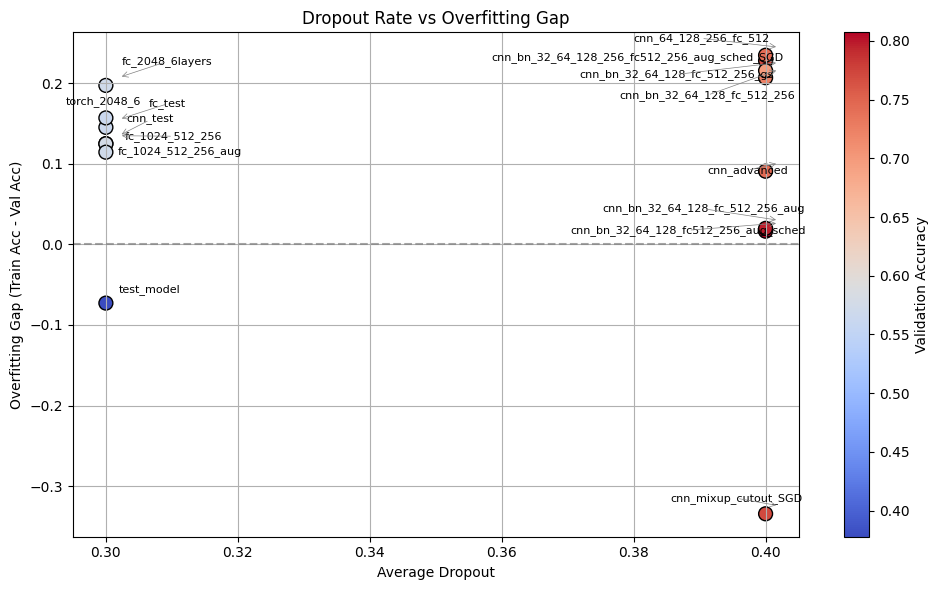

In [5]:
df_models["Dropout Avg"] = df_models["Dropout"].apply(lambda d: np.mean(eval(d)) if isinstance(d, str) else np.nan)
plot_dropout_vs_overfit(df_models)

#### Model Efficiency

This chart compares models by their **efficiency**, defined as:

$
\text{Efficiency} = \frac{\text{Validation Accuracy}}{\text{Average Epoch Time (s)}}
$

Higher values indicate models that achieve good accuracy with less training time per epoch.


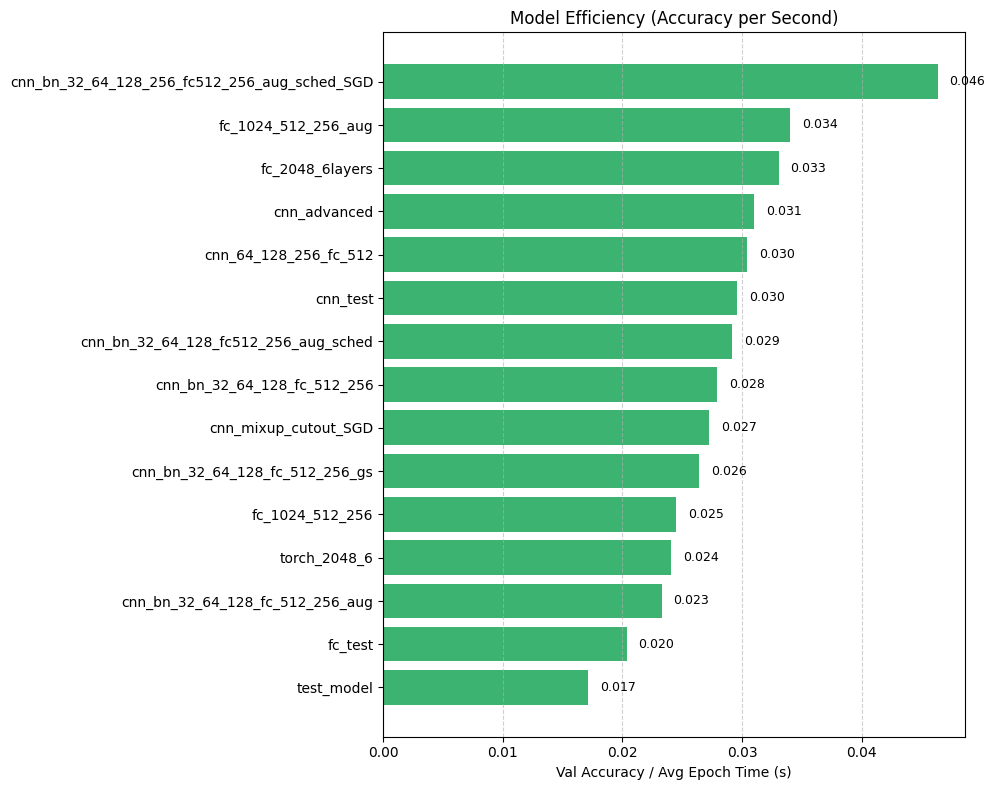

In [6]:
df_models["Efficiency"] = df_models["Val Acc"] / df_models["Avg Epoch Time (s)"]

plot_efficiency(df_models)

#### Model Accuracy by Architecture Type

This boxplot shows the distribution of model accuracy grouped by architecture type: **CNN** (Convolutional Neural Networks) and **FC** (Fully Connected networks).

Two metrics are shown:
- **Val Acc**: Validation Accuracy
- **Test Acc**: Test Accuracy

The plot highlights how CNN-based architectures consistently outperform FC networks in both validation and test accuracy. The spread also indicates variability within CNNs, while FC models cluster closer together with lower performance.


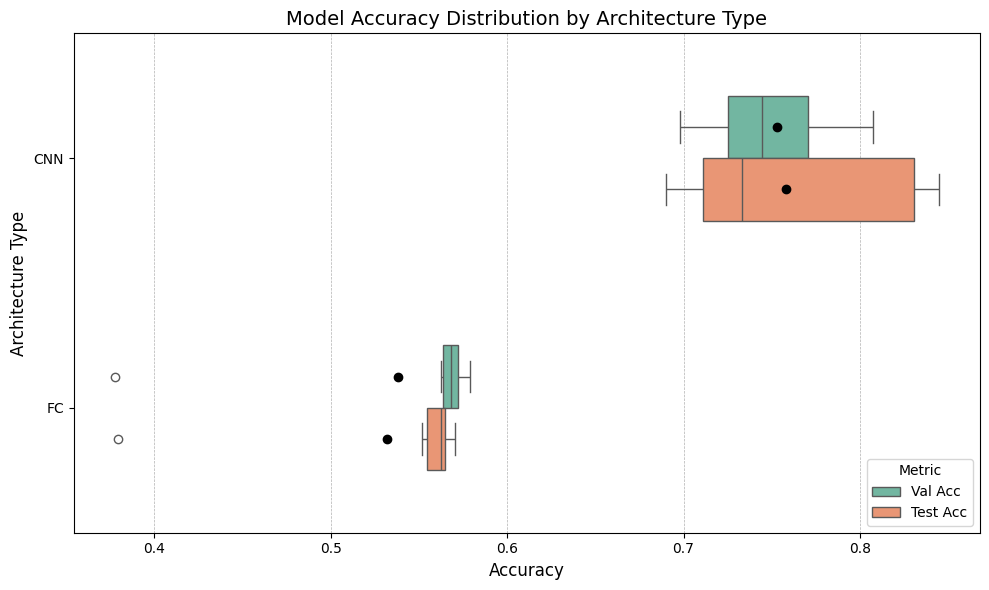

In [7]:
plot_group_accuracy(df_models)

#### 🔍 Comparison of Two Models

This section compares the selected models based on:
- **Confusion Matrices**: For an overview of misclassifications.
- **Per-Class F1-Scores**: Displayed in a sortable table.
- **F1 Difference Bar Plot**: Δ F1 between the two models per class (positive = better performance of second model).

⚙️ To compare models:
1. Run `interactive_model_comparison(test_results, class_names)` to display the UI.
2. Select models and click "Compare Models".
3. After each comparison, re-run the function to reset the interface.

✅ Output is cleared before each comparison to prevent clutter or duplicate visualizations.

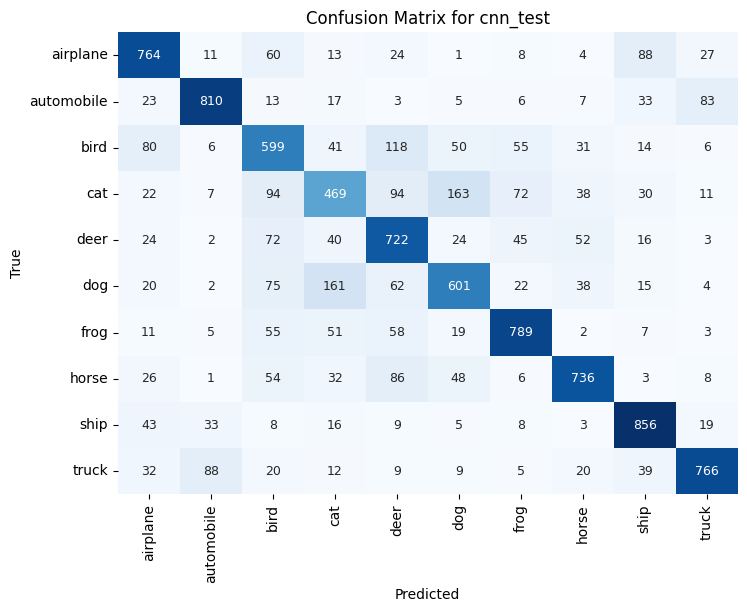

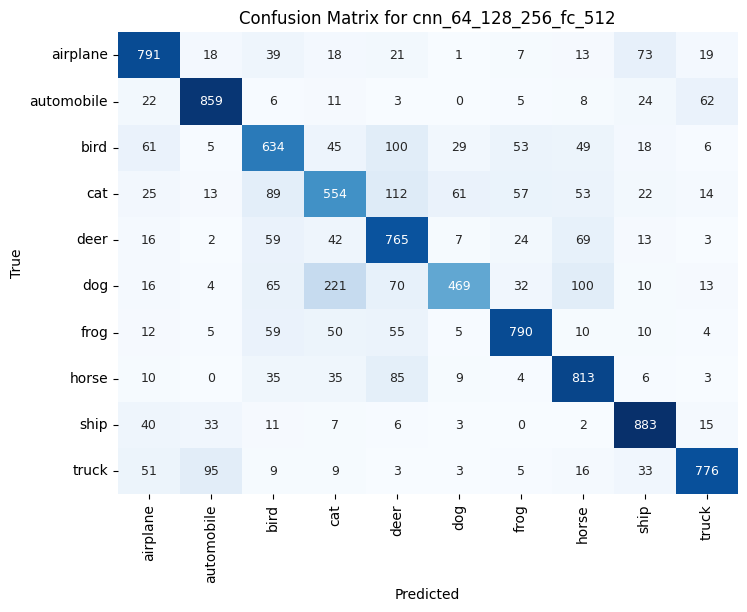


📊 F1-score comparison by class:



,cnn_test,cnn_64_128_256_fc_512,Δ F1
cat,0.506479,0.556225,0.0497
bird,0.584390,0.632104,0.0477
ship,0.814850,0.844168,0.0293
deer,0.660870,0.689189,0.0283
airplane,0.747188,0.773973,0.0268
automobile,0.824427,0.844641,0.0202
truck,0.793782,0.810444,0.0167
frog,0.782738,0.799191,0.0165
horse,0.762299,0.762307,0.0000
dog,0.624416,0.591052,-0.0334


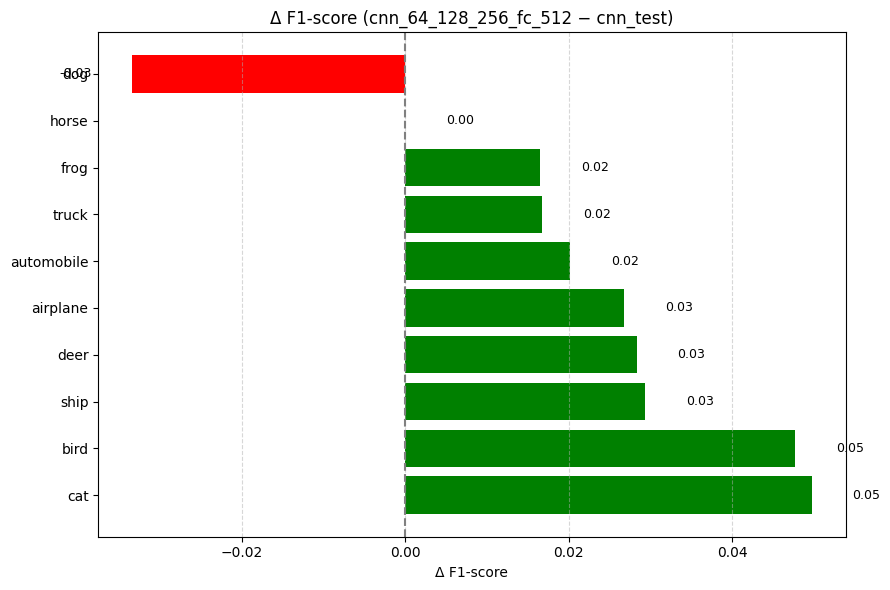

In [9]:
interactive_model_comparison(test_results, class_names)